In [1]:
import keras
from keras.models import Sequential, Model, load_model

from keras.layers import Dense, Dropout, Activation, Flatten, Input, Lambda
from keras.layers import Conv2D, MaxPooling2D, Conv1D, MaxPooling1D, LSTM, ConvLSTM2D, GRU, BatchNormalization, LocallyConnected2D, Permute
from keras.layers import Concatenate, Reshape, Softmax, Conv2DTranspose, Embedding, Multiply
from keras.callbacks import ModelCheckpoint, EarlyStopping, Callback
from keras import regularizers
from keras import backend as K
import keras.losses

import tensorflow as tf
from tensorflow.python.framework import ops

import isolearn.keras as iso

import numpy as np

import tensorflow as tf
import logging
logging.getLogger('tensorflow').setLevel(logging.ERROR)

import pandas as pd

import os
import pickle
import numpy as np

import scipy.sparse as sp
import scipy.io as spio

import matplotlib.pyplot as plt

import isolearn.keras as iso

from seqprop.visualization import *
from seqprop_generator_protein import *
from seqprop.predictor import *
from seqprop.optimizer import *

from definitions.trrosetta_single_model_no_msa import load_saved_predictor

import warnings
warnings.simplefilter("ignore")

from keras.backend.tensorflow_backend import set_session

def contain_tf_gpu_mem_usage() :
    config = tf.ConfigProto()
    config.gpu_options.allow_growth = True
    sess = tf.Session(config=config)
    set_session(sess)

contain_tf_gpu_mem_usage()

def one_hot_encode_msa(msa, ns=21) :
    
    one_hot = np.zeros((a3m.shape[0], a3m.shape[1], ns))
    for i in range(a3m.shape[0]) :
        for j in range(a3m.shape[1]) :
            one_hot[i, j, int(msa[i, j])] = 1.
    
    return one_hot

import string

def parse_a3m(filename):
    seqs = []
    table = str.maketrans(dict.fromkeys(string.ascii_lowercase))

    # read file line by line
    for line in open(filename,"r"):
        # skip labels
        if line[0] != '>':
            # remove lowercase letters and right whitespaces
            seqs.append(line.rstrip().translate(table))

    # convert letters into numbers
    alphabet = np.array(list("ARNDCQEGHILKMFPSTWYV-"), dtype='|S1').view(np.uint8)
    msa = np.array([list(s) for s in seqs], dtype='|S1').view(np.uint8)
    for i in range(alphabet.shape[0]):
        msa[msa == alphabet[i]] = i

    # treat all unknown characters as gaps
    msa[msa > 20] = 20

    return msa

def letterAt_protein(letter, x, y, yscale=1, ax=None, color='black', alpha=1.0):

    #fp = FontProperties(family="Arial", weight="bold")
    #fp = FontProperties(family="Ubuntu", weight="bold")
    fp = FontProperties(family="DejaVu Sans", weight="bold")
    
    globscale = 1.35
    LETTERS = {"T" : TextPath((-0.305, 0), "T", size=1, prop=fp),
               "G" : TextPath((-0.384, 0), "G", size=1, prop=fp),
               "A" : TextPath((-0.35, 0), "A", size=1, prop=fp),
               "C" : TextPath((-0.366, 0), "C", size=1, prop=fp),
               
               "L" : TextPath((-0.35, 0), "L", size=1, prop=fp),
               "M" : TextPath((-0.35, 0), "M", size=1, prop=fp),
               "F" : TextPath((-0.35, 0), "F", size=1, prop=fp),
               "W" : TextPath((-0.35, 0), "W", size=1, prop=fp),
               "K" : TextPath((-0.35, 0), "K", size=1, prop=fp),
               "Q" : TextPath((-0.35, 0), "Q", size=1, prop=fp),
               "E" : TextPath((-0.35, 0), "E", size=1, prop=fp),
               "S" : TextPath((-0.35, 0), "S", size=1, prop=fp),
               "P" : TextPath((-0.35, 0), "P", size=1, prop=fp),
               "V" : TextPath((-0.35, 0), "V", size=1, prop=fp),
               "I" : TextPath((-0.35, 0), "I", size=1, prop=fp),
               "Y" : TextPath((-0.35, 0), "Y", size=1, prop=fp),
               "H" : TextPath((-0.35, 0), "H", size=1, prop=fp),
               "R" : TextPath((-0.35, 0), "R", size=1, prop=fp),
               "N" : TextPath((-0.35, 0), "N", size=1, prop=fp),
               "D" : TextPath((-0.35, 0), "D", size=1, prop=fp),
               "U" : TextPath((-0.35, 0), "U", size=1, prop=fp),
               "!" : TextPath((-0.35, 0), "!", size=1, prop=fp),
               
               "UP" : TextPath((-0.488, 0), '$\\Uparrow$', size=1, prop=fp),
               "DN" : TextPath((-0.488, 0), '$\\Downarrow$', size=1, prop=fp),
               "(" : TextPath((-0.25, 0), "(", size=1, prop=fp),
               "." : TextPath((-0.125, 0), "-", size=1, prop=fp),
               ")" : TextPath((-0.1, 0), ")", size=1, prop=fp)}

    
    if letter in LETTERS :
        text = LETTERS[letter]
    else :
        text = TextPath((-0.35, 0), letter, size=1, prop=fp)
    
    chosen_color = color
    
    if chosen_color is None :
        chosen_color = 'black'
        if letter in ['A', 'I', 'L', 'M', 'F', 'W', 'V'] : #Hydrophobic
            chosen_color = 'blue'
        elif letter in ['K' ,'R'] : #Positive charge
            chosen_color = 'red'
        elif letter in ['E', 'D'] : #Negative charge
            chosen_color = 'magenta'
        elif letter in ['N', 'Q', 'S', 'T'] : #Polar
            chosen_color = 'green'
        elif letter in ['C'] : #Cysteines
            chosen_color = 'pink'
        elif letter in ['G'] : #Glycines
            chosen_color = 'orange'
        elif letter in ['P'] : #Prolines
            chosen_color = 'yellow'
        elif letter in ['H', 'Y'] : #Aromatic
            chosen_color = 'cyan'

    t = mpl.transforms.Affine2D().scale(1*globscale, yscale*globscale) + \
        mpl.transforms.Affine2D().translate(x,y) + ax.transData
    p = PathPatch(text, lw=0, fc=chosen_color, alpha=alpha, transform=t)
    if ax != None:
        ax.add_artist(p)
    return p


def plot_protein_logo(inv_residue_map, pwm, meas_str, score, sequence_template=None, figsize=(12, 3), width_ratios=[1, 7], logo_height=1.0, plot_start=0, plot_end=164) :

    #Slice according to seq trim index
    pwm = pwm[plot_start: plot_end, :]
    sequence_template = sequence_template[plot_start: plot_end]

    pwm += 0.0001
    for j in range(0, pwm.shape[0]) :
        pwm[j, :] /= np.sum(pwm[j, :])

    entropy = np.zeros(pwm.shape)
    entropy[pwm > 0] = pwm[pwm > 0] * -np.log2(pwm[pwm > 0])
    entropy = np.sum(entropy, axis=1)
    conservation = np.log2(len(inv_residue_map)) - entropy#2 - entropy

    fig = plt.figure(figsize=figsize)

    gs = gridspec.GridSpec(1, 2, width_ratios=[width_ratios[0], width_ratios[-1]])

    ax2 = plt.subplot(gs[0])
    ax3 = plt.subplot(gs[1])

    plt.sca(ax2)
    plt.axis('off')


    annot_text = '\n' + meas_str + ' = ' + str(round(score, 4))

    ax2.text(0.99, 0.5, annot_text, horizontalalignment='right', verticalalignment='center', transform=ax2.transAxes, color='black', fontsize=12, weight="bold")

    height_base = (1.0 - logo_height) / 2.

    for j in range(0, pwm.shape[0]) :
        sort_index = np.argsort(pwm[j, :])

        for ii in range(0, len(inv_residue_map)) :
            i = sort_index[ii]

            nt_prob = pwm[j, i] * conservation[j]

            nt = inv_residue_map[i]

            color = None
            if sequence_template[j] != '$' :
                color = 'black'

            if ii == 0 :
                letterAt_protein(nt, j + 0.5, height_base, nt_prob * logo_height, ax3, color=color)
            else :
                prev_prob = np.sum(pwm[j, sort_index[:ii]] * conservation[j]) * logo_height
                letterAt_protein(nt, j + 0.5, height_base + prev_prob, nt_prob * logo_height, ax3, color=color)

    plt.sca(ax3)

    plt.xlim((0, plot_end - plot_start))
    plt.ylim((0, np.log2(len(inv_residue_map))))
    plt.xticks([], [])
    plt.yticks([], [])
    plt.axis('off')
    ax3.axhline(y=0.01 + height_base, color='black', linestyle='-', linewidth=2)


    for axis in fig.axes :
        axis.get_xaxis().set_visible(False)
        axis.get_yaxis().set_visible(False)

    plt.tight_layout()

    plt.show()


Using TensorFlow backend.


In [2]:
#Simulated annealing (Basin hopping)

from scipy.optimize import basinhopping, OptimizeResult

class IdentityEncoder(iso.SequenceEncoder) :
    
    def __init__(self, seq_len, channel_map) :
        super(IdentityEncoder, self).__init__('identity', (seq_len, len(channel_map)))
        
        self.seq_len = seq_len
        self.n_channels = len(channel_map)
        self.encode_map = channel_map
        self.decode_map = {
            nt: ix for ix, nt in self.encode_map.items()
        }
    
    def encode(self, seq) :
        encoding = np.zeros((self.seq_len, self.n_channels))
        
        for i in range(len(seq)) :
            if seq[i] in self.encode_map :
                channel_ix = self.encode_map[seq[i]]
                encoding[i, channel_ix] = 1.

        return encoding
    
    def encode_inplace(self, seq, encoding) :
        for i in range(len(seq)) :
            if seq[i] in self.encode_map :
                channel_ix = self.encode_map[seq[i]]
                encoding[i, channel_ix] = 1.
    
    def encode_inplace_sparse(self, seq, encoding_mat, row_index) :
        raise NotImplementError()
    
    def decode(self, encoding) :
        seq = ''
    
        for pos in range(0, encoding.shape[0]) :
            argmax_nt = np.argmax(encoding[pos, :])
            max_nt = np.max(encoding[pos, :])
            seq += self.decode_map[argmax_nt]

        return seq
    
    def decode_sparse(self, encoding_mat, row_index) :
        raise NotImplementError()


def get_step_func(predictor, sequence_template, acgt_encoder, n_swaps=1) :
    
    available_positions = [
        j for j in range(len(sequence_template)) if sequence_template[j] == '$'
    ]
    
    residues = list("ARNDCQEGHILKMFPSTWYV")
    
    available_nt_dict = {
        residue_ix : [residue_ix_2 for residue_ix_2 in range(len(residues)) if residue_ix_2 != residue_ix]
        for residue_ix in range(len(residues))
        #0 : [1, 2, 3],
        #1 : [0, 2, 3],
        #2 : [1, 0, 3],
        #3 : [1, 2, 0]
    }
        
    #_predict_func = get_predict_func(predictor, len(sequence_template))
    
    def _step_func(x, sequence_template=sequence_template, available_positions=available_positions, available_nt_dict=available_nt_dict, n_swaps=n_swaps) :
        
        onehot = np.expand_dims(np.expand_dims(x.reshape((len(sequence_template), 20)), axis=0), axis=-1)
        
        #Choose random position and nucleotide identity
        for swap_i in range(n_swaps) :
            rand_pos = np.random.choice(available_positions)

            curr_nt = np.argmax(onehot[0, rand_pos, :, 0])
            rand_nt = np.random.choice(available_nt_dict[curr_nt])

            #Swap nucleotides
            onehot[0, rand_pos, :, 0] = 0.
            onehot[0, rand_pos, rand_nt, 0] = 1.
        
        new_x = np.ravel(onehot)
        
        return new_x
    
    return _step_func

def get_predict_func(predictor, t_distos, msa_one_hot, seq_len) :
    
    def _predict_func(x, predictor=predictor, seq_len=seq_len, t_distos=t_distos, msa_one_hot=msa_one_hot) :
        
        td, tt, tp, to = t_distos
        
        onehot = np.expand_dims(x.reshape((seq_len, 20)), axis=0)
        
        msa_one_hot = np.expand_dims(onehot, axis=0)
        msa_one_hot = np.concatenate([msa_one_hot, np.zeros((1, 1, msa_one_hot.shape[2], 1))], axis=-1)
        
        p_dist, p_theta, p_phi, p_omega = predictor.predict(x=[onehot, msa_one_hot], batch_size=1)
        
        t_dist = np.clip(td, 1e-7, 1. - 1e-7)
        t_theta = np.clip(tt, 1e-7, 1. - 1e-7)
        t_phi = np.clip(tp, 1e-7, 1. - 1e-7)
        t_omega = np.clip(to, 1e-7, 1. - 1e-7)
        
        kl_dist = np.mean(np.sum(t_dist * np.log(t_dist / p_dist), axis=-1))
        kl_theta = np.mean(np.sum(t_theta * np.log(t_theta / p_theta), axis=-1))
        kl_phi = np.mean(np.sum(t_phi * np.log(t_phi / p_phi), axis=-1))
        kl_omega = np.mean(np.sum(t_omega * np.log(t_omega / p_omega), axis=-1))

        return kl_dist + kl_theta + kl_phi + kl_omega
    
    return _predict_func

def get_predict_func_smooth_kl(predictor, t_distos, msa_one_hot, seq_len) :
    
    def _predict_func_smooth_kl(x, predictor=predictor, seq_len=seq_len, t_distos=t_distos, msa_one_hot=msa_one_hot) :
        
        td, tt, tp, to = t_distos
        
        onehot = np.expand_dims(x.reshape((seq_len, 20)), axis=0)
        
        msa_one_hot = np.expand_dims(onehot, axis=0)
        msa_one_hot = np.concatenate([msa_one_hot, np.zeros((1, 1, msa_one_hot.shape[2], 1))], axis=-1)
        
        p_dist, p_theta, p_phi, p_omega = predictor.predict(x=[onehot, msa_one_hot], batch_size=1)
        
        t_dist = np.clip(t_pd, 1e-7, 1. - 1e-7)
        t_theta = np.clip(t_pt, 1e-7, 1. - 1e-7)
        t_phi = np.clip(t_pp, 1e-7, 1. - 1e-7)
        t_omega = np.clip(t_po, 1e-7, 1. - 1e-7)

        pd_val = np.sum(p_dist * np.tile(np.reshape(np.arange(p_dist.shape[3]), (1, 1, 1, p_dist.shape[3])), (1, p_dist.shape[1], p_dist.shape[2], 1)), axis=-1) / p_dist.shape[3]
        pt_val = np.sum(p_theta * np.tile(np.reshape(np.arange(p_theta.shape[3]), (1, 1, 1, p_theta.shape[3])), (1, p_theta.shape[1], p_theta.shape[2], 1)), axis=-1) / p_theta.shape[3]
        pp_val = np.sum(p_phi * np.tile(np.reshape(np.arange(p_phi.shape[3]), (1, 1, 1, p_phi.shape[3])), (1, p_phi.shape[1], p_phi.shape[2], 1)), axis=-1) / p_phi.shape[3]
        po_val = np.sum(p_omega * np.tile(np.reshape(np.arange(p_omega.shape[3]), (1, 1, 1, p_omega.shape[3])), (1, p_omega.shape[1], p_omega.shape[2], 1)), axis=-1) / p_omega.shape[3]

        td_val = np.sum(t_dist * np.tile(np.reshape(np.arange(t_dist.shape[3]), (1, 1, 1, t_dist.shape[3])), (1, t_dist.shape[1], t_dist.shape[2], 1)), axis=-1) / t_dist.shape[3]
        tt_val = np.sum(t_theta * np.tile(np.reshape(np.arange(t_theta.shape[3]), (1, 1, 1, t_theta.shape[3])), (1, t_theta.shape[1], t_theta.shape[2], 1)), axis=-1) / t_theta.shape[3]
        tp_val = np.sum(t_phi * np.tile(np.reshape(np.arange(t_phi.shape[3]), (1, 1, 1, t_phi.shape[3])), (1, t_phi.shape[1], t_phi.shape[2], 1)), axis=-1) / t_phi.shape[3]
        to_val = np.sum(t_omega * np.tile(np.reshape(np.arange(t_omega.shape[3]), (1, 1, 1, t_omega.shape[3])), (1, t_omega.shape[1], t_omega.shape[2], 1)), axis=-1) / t_omega.shape[3]

        kl_dist = np.mean(td_val * np.log(td_val / pd_val))
        kl_theta = np.mean(tt_val * np.log(tt_val / pt_val))
        kl_phi = np.mean(tp_val * np.log(tp_val / pp_val))
        kl_omega = np.mean(to_val * np.log(to_val / po_val))

        return kl_dist + kl_theta + kl_phi + kl_omega
    
    return _predict_func_smooth_kl

def run_simulated_annealing(predictor, t_distos, msa_one_hot, sequence_template, acgt_encoder, n_iters=1000, n_iters_per_temperate=100, temperature_init=1.0, temperature_func=None, n_swaps=1, verbose=False) :
    
    if temperature_func is None :
        temperature_func = lambda t, curr_iter, t_init=temperature_init, total_iters=n_iters: t
    
    n_epochs = n_iters // n_iters_per_temperate
    
    predict_func = get_predict_func(predictor, t_distos, msa_one_hot, len(sequence_template))
    predict_func_smooth_kl = get_predict_func_smooth_kl(predictor, t_distos, msa_one_hot, len(sequence_template))
    step_func = get_step_func(predictor, sequence_template, acgt_encoder, n_swaps=n_swaps)
    
    #Random initialization
    random_sequence = ''.join([
        sequence_template[j] if sequence_template[j] != '$' else np.random.choice(list("ARNDCQEGHILKMFPSTWYV"))
        for j in range(len(sequence_template))
    ])

    x0 = np.ravel(acgt_encoder.encode(random_sequence))
    
    x = x0
    temperature = temperature_init
    
    tracked_scores = [-predict_func(x)]
    tracked_scores_smooth = [-predict_func_smooth_kl(x)]
    for epoch_ix in range(n_epochs) :
        
        x_opt, f_opt = run_basinhopping(x, predict_func, step_func, n_iters=n_iters_per_temperate, temperature=temperature)
    
        score_opt = -f_opt
        tracked_scores.append(score_opt)
        tracked_scores_smooth.append(-predict_func_smooth_kl(x_opt))
        
        if verbose :
            print("Iter " + str((epoch_ix + 1) * n_iters_per_temperate) + ", Temp = " + str(round(temperature, 4)) + ", Score = " + str(round(score_opt, 4)) + "...")

        x = x_opt
        temperature = temperature_func(temperature, (epoch_ix + 1) * n_iters_per_temperate)
    
    onehot_opt = np.expand_dims(np.expand_dims(x.reshape((len(sequence_template), 20)), axis=0), axis=-1)
    seq_opt = acgt_encoder.decode(onehot_opt[0, :, :, 0])
    
    return seq_opt, np.array(tracked_scores), np.array(tracked_scores_smooth)

def run_basinhopping(x, predict_func, step_func, n_iters=1000, temperature=1.0) :
    
    def _dummy_min_opt(fun, x0, args=(), **options) :
        return OptimizeResult(fun=fun(x0), x=x0, nit=0, nfev=0, success=True)
    
    minimizer_kwargs = {
        'method' : _dummy_min_opt,
        'options' : { 'maxiter' : 0 }
    }
    
    opt_res = basinhopping(predict_func, x, minimizer_kwargs=minimizer_kwargs, stepsize=None, niter=n_iters, T=temperature, take_step=step_func)
    
    return opt_res.x, opt_res.fun

def run_simulated_annealing_batch(saved_predictor, t_distos, msa_one_hot, sequence_template, acgt_encoder, n_sequences=1, n_iters=1000, n_iters_per_temperate=100, temperature_init=1.0, temperature_func=None, n_swaps=1, verbose=False) :
    
    f = plt.figure(figsize=(6, 4))

    it_space = [0] + [(epoch_ix + 1) * n_iters_per_temperate for epoch_ix in range(n_iters // n_iters_per_temperate)]
    temp = temperature_init
    temp_space = [temp]
    for j in range(1, len(it_space)) :
        it = it_space[j]
        temp = temperature_func(temp, it)
        temp_space.append(temp)

    plt.plot(it_space, temp_space, linewidth=2, color='black', linestyle='-')

    plt.xlabel("Iteration", fontsize=14)
    plt.ylabel("Temperature", fontsize=14)
    plt.title("Anneal schedule", fontsize=14)

    plt.xlim(0, np.max(it_space))

    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)

    plt.tight_layout()
    plt.show()
    
    optimized_seqs = []
    optimized_trajs = []
    optimized_trajs_smooth_kl = []
    for sequence_ix in range(n_sequences) :

        seq, scores, scores_smooth_kl = run_simulated_annealing(saved_predictor, t_distos, msa_one_hot, sequence_template, acgt_encoder, n_iters=n_iters, n_iters_per_temperate=n_iters_per_temperate, temperature_init=temperature_init, temperature_func=temperature_func, n_swaps=n_swaps, verbose=verbose)

        optimized_seqs.append(seq)
        optimized_trajs.append(scores.reshape(1, -1))
        optimized_trajs_smooth_kl.append(scores_smooth_kl.reshape(1, -1))

    optimized_trajs = np.concatenate(optimized_trajs, axis=0)
    optimized_trajs_smooth_kl = np.concatenate(optimized_trajs_smooth_kl, axis=0)
    
    print("[Basinhopping] Finished optimizing " + str(n_sequences) + " sequences.")
    
    return optimized_seqs, optimized_trajs, optimized_trajs_smooth_kl


In [3]:

#Define target isoform loss function
def get_kl_loss(target_p_dist, target_p_theta, target_p_phi, target_p_omega) :
    
    def loss_func(predictor_outputs) :
        pwm_logits, pwm, sampled_pwm, p_dist, p_theta, p_phi, p_omega = predictor_outputs

        t_dist = K.clip(K.constant(target_p_dist), K.epsilon(), 1. - K.epsilon())
        t_theta = K.clip(K.constant(target_p_theta), K.epsilon(), 1. - K.epsilon())
        t_phi = K.clip(K.constant(target_p_phi), K.epsilon(), 1. - K.epsilon())
        t_omega = K.clip(K.constant(target_p_omega), K.epsilon(), 1. - K.epsilon())
        
        kl_dist = K.mean(K.sum(t_dist * K.log(t_dist / p_dist), axis=-1), axis=(-1, -2))
        kl_theta = K.mean(K.sum(t_theta * K.log(t_theta / p_theta), axis=-1), axis=(-1, -2))
        kl_phi = K.mean(K.sum(t_phi * K.log(t_phi / p_phi), axis=-1), axis=(-1, -2))
        kl_omega = K.mean(K.sum(t_omega * K.log(t_omega / p_omega), axis=-1), axis=(-1, -2))
        
        #Specify costs
        fitness_loss = K.mean(kl_dist + kl_theta + kl_phi + kl_omega, axis=0)
        
        #Compute total loss
        total_loss = fitness_loss

        return K.reshape(K.sum(total_loss, axis=0), (1,))
    
    def val_loss_func(predictor_outputs) :
        pwm_logits, pwm, sampled_pwm, p_dist, p_theta, p_phi, p_omega = predictor_outputs

        t_dist = K.clip(K.constant(target_p_dist), K.epsilon(), 1. - K.epsilon())
        t_theta = K.clip(K.constant(target_p_theta), K.epsilon(), 1. - K.epsilon())
        t_phi = K.clip(K.constant(target_p_phi), K.epsilon(), 1. - K.epsilon())
        t_omega = K.clip(K.constant(target_p_omega), K.epsilon(), 1. - K.epsilon())
        
        kl_dist = K.mean(K.sum(t_dist * K.log(t_dist / p_dist), axis=-1), axis=(-1, -2))
        kl_theta = K.mean(K.sum(t_theta * K.log(t_theta / p_theta), axis=-1), axis=(-1, -2))
        kl_phi = K.mean(K.sum(t_phi * K.log(t_phi / p_phi), axis=-1), axis=(-1, -2))
        kl_omega = K.mean(K.sum(t_omega * K.log(t_omega / p_omega), axis=-1), axis=(-1, -2))
        
        #Specify costs
        fitness_loss = K.mean(kl_dist + kl_theta + kl_phi + kl_omega, axis=0)
        
        #Compute total loss
        total_loss = fitness_loss

        return K.reshape(K.sum(total_loss, axis=0), (1,))
    
    def val_loss_func_smooth_kl(predictor_outputs) :
        pwm_logits, pwm, sampled_pwm, p_dist, p_theta, p_phi, p_omega = predictor_outputs

        t_dist = K.clip(K.constant(target_p_dist), K.epsilon(), 1. - K.epsilon())
        t_theta = K.clip(K.constant(target_p_theta), K.epsilon(), 1. - K.epsilon())
        t_phi = K.clip(K.constant(target_p_phi), K.epsilon(), 1. - K.epsilon())
        t_omega = K.clip(K.constant(target_p_omega), K.epsilon(), 1. - K.epsilon())
        
        pd_val = K.sum(p_dist * K.tile(K.reshape(K.constant(np.arange(target_p_dist.shape[3])), (1, 1, 1, target_p_dist.shape[3])), (1, target_p_dist.shape[1], target_p_dist.shape[2], 1)), axis=-1) / K.constant(target_p_dist.shape[3])
        pt_val = K.sum(p_theta * K.tile(K.reshape(K.constant(np.arange(target_p_theta.shape[3])), (1, 1, 1, target_p_theta.shape[3])), (1, target_p_theta.shape[1], target_p_theta.shape[2], 1)), axis=-1) / K.constant(target_p_theta.shape[3])
        pp_val = K.sum(p_phi * K.tile(K.reshape(K.constant(np.arange(target_p_phi.shape[3])), (1, 1, 1, target_p_phi.shape[3])), (1, target_p_phi.shape[1], target_p_phi.shape[2], 1)), axis=-1) / K.constant(target_p_phi.shape[3])
        po_val = K.sum(p_omega * K.tile(K.reshape(K.constant(np.arange(target_p_omega.shape[3])), (1, 1, 1, target_p_omega.shape[3])), (1, target_p_omega.shape[1], target_p_omega.shape[2], 1)), axis=-1) / K.constant(target_p_omega.shape[3])

        td_val = K.sum(t_dist * K.tile(K.reshape(K.constant(np.arange(target_p_dist.shape[3])), (1, 1, 1, target_p_dist.shape[3])), (1, target_p_dist.shape[1], target_p_dist.shape[2], 1)), axis=-1) / K.constant(target_p_dist.shape[3])
        tt_val = K.sum(t_theta * K.tile(K.reshape(K.constant(np.arange(target_p_theta.shape[3])), (1, 1, 1, target_p_theta.shape[3])), (1, target_p_theta.shape[1], target_p_theta.shape[2], 1)), axis=-1) / K.constant(target_p_theta.shape[3])
        tp_val = K.sum(t_phi * K.tile(K.reshape(K.constant(np.arange(target_p_phi.shape[3])), (1, 1, 1, target_p_phi.shape[3])), (1, target_p_phi.shape[1], target_p_phi.shape[2], 1)), axis=-1) / K.constant(target_p_phi.shape[3])
        to_val = K.sum(t_omega * K.tile(K.reshape(K.constant(np.arange(target_p_omega.shape[3])), (1, 1, 1, target_p_omega.shape[3])), (1, target_p_omega.shape[1], target_p_omega.shape[2], 1)), axis=-1) / K.constant(target_p_omega.shape[3])

        kl_dist = K.mean(td_val * K.log(td_val / pd_val), axis=(-1, -2))
        kl_theta = K.mean(tt_val * K.log(tt_val / pt_val), axis=(-1, -2))
        kl_phi = K.mean(tp_val * K.log(tp_val / pp_val), axis=(-1, -2))
        kl_omega = K.mean(to_val * K.log(to_val / po_val), axis=(-1, -2))
        
        #Specify costs
        fitness_loss = K.mean(kl_dist + kl_theta + kl_phi + kl_omega, axis=0)
        
        #Compute total loss
        total_loss = fitness_loss

        return K.reshape(K.sum(total_loss, axis=0), (1,))
    
    return loss_func, val_loss_func, val_loss_func_smooth_kl


def get_nop_transform() :
    
    def _transform_func(pwm) :
        
        return pwm
    
    return _transform_func

class ValidationCallback(Callback):
    def __init__(self, val_name, val_loss_model, val_steps) :
        self.val_name = val_name
        self.val_loss_model = val_loss_model
        self.val_steps = val_steps
        
        self.val_loss_history = []
        
        #Track val loss
        self.val_loss_history.append(self.val_loss_model.predict(x=None, steps=self.val_steps)[0])
    
    def on_batch_end(self, batch, logs={}) :
        #Track val loss
        val_loss_value = self.val_loss_model.predict(x=None, steps=self.val_steps)[0]
        self.val_loss_history.append(val_loss_value)


class DummyValidationCallback(Callback):
    def __init__(self, val_name) :
        self.val_name = val_name
        
        self.val_loss_history = []

class DummyFlexibleSeqPropMonitor(Callback):
    def __init__(self, measure_name='Measure') :
        self.measure_name = measure_name
        self.measure_history = [] = []
        self.entropy_history = []
        self.nt_swap_history = []
        self.prev_optimized_pwm = None

        self.n_epochs = 0

from definitions.trrosetta_single_model import reweight, msa2pssm, fast_dca, InstanceNormalization

def _tmp_load_model(model_path) :

    ckpt = "../../../trRosetta/network/model2019_07/model.xaa"

    saved_model = load_model(ckpt + ".h5", custom_objects = {
        'InstanceNormalization' : InstanceNormalization,
        'reweight' : reweight,
        'wmin' : 0.8,
        'msa2pssm' : msa2pssm,
        'tf' : tf,
        'fast_dca' : fast_dca
    })
    
    return saved_model


#Function for running SeqProp on a set of objectives to optimize
def run_seqprop(loss_funcs, val_loss_funcs, val_loss_funcs_smooth_kl, transform_funcs, temperature_params, t_distos, msa_one_hots, seq_length=100, n_sequences=1, n_samples=1, n_valid_samples=1, eval_mode='sample', normalize_logits=False, n_epochs=10, steps_per_epoch=100) :
    
    if eval_mode == 'basinhopping' :
        residues = list("ARNDCQEGHILKMFPSTWYV")
        residue_map = {
            residue : residue_ix
            for residue_ix, residue in enumerate(residues)
        }
        acgt_encoder = IdentityEncoder(seq_length, residue_map)
        
        predictor = _tmp_load_model(model_path)
        predictor.compile(
            loss='mse',
            optimizer=keras.optimizers.SGD(lr=0.1)
        )
        
        n_iters_per_temperate, n_swaps, t_init, t_func = temperature_params[0]
        
        evolved_sequences, evolved_scores, evolved_scores_smooth_kl = run_simulated_annealing_batch(predictor, t_distos, msa_one_hots[0], "$" * seq_length, acgt_encoder, n_sequences=n_sequences, n_iters=steps_per_epoch, n_iters_per_temperate=n_iters_per_temperate, temperature_init=t_init, temperature_func=t_func, n_swaps=n_swaps, verbose=False)
        evolved_losses = -evolved_scores
        evolved_losses_smooth_kl = -evolved_scores_smooth_kl
        
        train_history = DummyValidationCallback('loss')
        train_history.val_loss_history = np.mean(evolved_losses * n_sequences, axis=0).tolist()
        
        valid_history = DummyValidationCallback('val_loss')
        valid_history.val_loss_history = np.mean(evolved_losses, axis=0).tolist()
        
        valid_history_smooth_kl = DummyValidationCallback('val_loss_smooth_kl')
        valid_history_smooth_kl.val_loss_history = np.mean(evolved_losses_smooth_kl, axis=0).tolist()
        
        opt_pwm = np.expand_dims(np.expand_dims(acgt_encoder.encode(evolved_sequences[0]), axis=-1), axis=0)
        
        return [opt_pwm], [train_history], [valid_history], [valid_history_smooth_kl]
    
    n_objectives = len(loss_funcs)
    
    seqprop_predictors = []
    valid_monitors = []
    train_histories = []
    valid_histories = []
    valid_histories_smooth_kl = []
    
    for obj_ix in range(n_objectives) :
        print("Optimizing objective " + str(obj_ix) + '...')
        
        loss_func = loss_funcs[obj_ix]
        val_loss_func = val_loss_funcs[obj_ix]
        val_loss_func_smooth_kl = val_loss_funcs_smooth_kl[obj_ix]
        transform_func = transform_funcs[obj_ix]
        msa_one_hot = msa_one_hots[obj_ix]
        
        #Build Generator Network
        _, seqprop_generator = build_generator(seq_length=seq_length, n_sequences=n_sequences, n_samples=n_samples, batch_normalize_pwm=normalize_logits, pwm_transform_func=transform_func, validation_sample_mode='sample')
        #for layer in seqprop_generator.layers :
        #    if 'policy' not in layer.name :
        #        layer.name += "_trainversion"
        _, valid_generator = build_generator(seq_length=seq_length, n_sequences=n_sequences, n_samples=n_valid_samples, batch_normalize_pwm=normalize_logits, pwm_transform_func=None, validation_sample_mode='max', master_generator=seqprop_generator)
        for layer in valid_generator.layers :
            #if 'policy' not in layer.name :
            layer.name += "_valversion"
        
        #Build Predictor Network and hook it on the generator PWM output tensor
        _, seqprop_predictor = build_predictor(seqprop_generator, load_saved_predictor(model_path, msa_one_hot=msa_one_hot), n_sequences=n_sequences, n_samples=n_samples, eval_mode=eval_mode)
        #for layer in seqprop_predictor.layers :
        #    if '_trainversion' not in layer.name and 'policy' not in layer.name :
        #        layer.name += "_trainversion"
        _, valid_predictor = build_predictor(valid_generator, load_saved_predictor(model_path, msa_one_hot=msa_one_hot), n_sequences=n_sequences, n_samples=n_valid_samples, eval_mode='sample')
        for layer in valid_predictor.layers :
            if '_valversion' not in layer.name :# and 'policy' not in layer.name :
                layer.name += "_valversion"
        
        #Build Loss Model (In: Generator seed, Out: Loss function)
        _, loss_model = build_loss_model(seqprop_predictor, loss_func)
        _, valid_loss_model = build_loss_model(valid_predictor, val_loss_func)
        _, valid_loss_model_smooth_kl = build_loss_model(valid_predictor, val_loss_func_smooth_kl)
        
        #Specify Optimizer to use
        #opt = keras.optimizers.SGD(lr=0.5)
        #opt = keras.optimizers.SGD(lr=0.1, momentum=0.9, decay=0, nesterov=True)
        opt = keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999)
        #opt = keras.optimizers.Adam(lr=0.001, beta_1=0.5, beta_2=0.9)
        
        #Compile Loss Model (Minimize self)
        loss_model.compile(loss=lambda true, pred: pred, optimizer=opt)

        def get_logit(p) :
            return np.log(p / (1. - p))
        
        #Specify callback entities
        #measure_func = lambda pred_outs: np.mean(get_logit(np.expand_dims(pred_outs[0], axis=0) if len(pred_outs[0].shape) <= 2 else pred_outs[0]), axis=0)
        #measure_func = lambda pred_outs: np.mean(np.expand_dims(pred_outs[1], axis=0) if len(pred_outs[1].shape) <= 2 else pred_outs[1], axis=0)
        
        #train_monitor = FlexibleSeqPropMonitor(predictor=seqprop_predictor, plot_on_train_end=False, plot_every_epoch=False, track_every_step=True, measure_func=measure_func, measure_name='Binding Log Odds', plot_pwm_start=500, plot_pwm_end=700, sequence_template=sequence_template, plot_pwm_indices=np.arange(n_sequences).tolist(), figsize=(12, 1.0))
        #valid_monitor = FlexibleSeqPropMonitor(predictor=valid_predictor, plot_on_train_end=True, plot_every_epoch=False, track_every_step=True, measure_func=measure_func, measure_name='Binding Log Odds', plot_pwm_start=500, plot_pwm_end=600, sequence_template=sequence_template, plot_pwm_indices=np.arange(n_sequences).tolist(), figsize=(12, 1.0))
        
        train_history = ValidationCallback('loss', loss_model, 1)
        valid_history = ValidationCallback('val_loss', valid_loss_model, 1)
        valid_history_smooth_kl = ValidationCallback('val_loss_smooth_kl', valid_loss_model_smooth_kl, 1)
        
        callbacks =[
            #EarlyStopping(monitor='loss', min_delta=0.001, patience=5, verbose=0, mode='auto'),
            #valid_monitor,
            train_history,
            valid_history,
            valid_history_smooth_kl
        ]
        
        #Fit Loss Model
        _ = loss_model.fit(
            [], np.ones((1, 1)), #Dummy training example
            epochs=n_epochs,
            steps_per_epoch=steps_per_epoch,
            callbacks=callbacks
        )
        
        #valid_monitor.predictor = None
        train_history.val_loss_model = None
        valid_history.val_loss_model = None
        valid_history_smooth_kl.val_loss_model = None
        
        _, opt_pwm, _, _, _, _, _ = seqprop_predictor.predict(x=None, steps=1)
        
        seqprop_predictors.append(opt_pwm)
        #valid_monitors.append(valid_monitor)
        train_histories.append(train_history)
        valid_histories.append(valid_history)
        valid_histories_smooth_kl.append(valid_history_smooth_kl)

    return seqprop_predictors, train_histories, valid_histories, valid_histories_smooth_kl


In [4]:
#Specfiy file path to pre-trained predictor network

save_dir = os.path.join(os.getcwd(), 'trRosetta/network/model2019_07')
model_name = 'model.xaa.h5'
model_path = os.path.join(save_dir, model_name)


In [5]:
import random

def set_seed(seed_value) :
    # 1. Set the `PYTHONHASHSEED` environment variable at a fixed value
    os.environ['PYTHONHASHSEED']=str(seed_value)

    # 2. Set the `python` built-in pseudo-random generator at a fixed value
    random.seed(seed_value)

    # 3. Set the `numpy` pseudo-random generator at a fixed value
    np.random.seed(seed_value)

    # 4. Set the `tensorflow` pseudo-random generator at a fixed value
    tf.set_random_seed(seed_value)

    # 5. Configure a new global `tensorflow` session
    session_conf = tf.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
    sess = tf.Session(graph=tf.get_default_graph(), config=session_conf)
    K.set_session(sess)


(1, 1, 72, 21)
(1, 72, 72, 37)


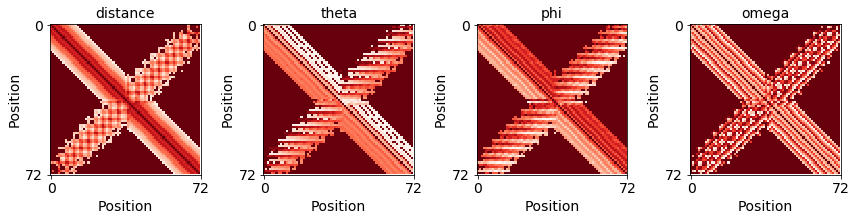

In [6]:
msa_file = "trRosetta/example/TR005257.a3m"

fig_name = "TR005257"
save_figs = True

a3m = parse_a3m(msa_file)

msa_one_hot = np.expand_dims(one_hot_encode_msa(a3m), axis=0)[:, :1, ...]

print(msa_one_hot.shape)

npz_file = "trRosetta/example/TR005257_xaa.npz"

npz_data = np.load(npz_file)

t_pd, t_pt, t_pp, t_po = npz_data['dist'], npz_data['omega'], npz_data['theta'], npz_data['phi']

print(t_pd.shape)


f, ax_list = plt.subplots(1, 4, figsize=(12, 3))

p_list = [
    [t_pd, 'distance', ax_list[0]],
    [t_pt, 'theta', ax_list[1]],
    [t_pp, 'phi', ax_list[2]],
    [t_po, 'omega', ax_list[3]]
]

for p_keras, p_name, p_ax in p_list :

    p_keras_vals = np.argmax(p_keras[0, ...], axis=-1)

    p_ax.imshow(np.max(p_keras_vals) - p_keras_vals, cmap="Reds", vmin=0, vmax=np.max(p_keras_vals))

    p_ax.set_title(p_name, fontsize=14)
    p_ax.set_xlabel("Position", fontsize=14)
    p_ax.set_ylabel("Position", fontsize=14)

    plt.sca(p_ax)

    plt.xticks([0, p_keras_vals.shape[0]], [0, p_keras_vals.shape[0]], fontsize=14)
    plt.yticks([0, p_keras_vals.shape[1]], [0, p_keras_vals.shape[1]], fontsize=14)

plt.tight_layout()

if save_figs :
    plt.savefig(fig_name + '_t_distribs.png', transparent=True, dpi=150)
    plt.savefig(fig_name + '_t_distribs.svg')
    plt.savefig(fig_name + '_t_distribs.eps')

plt.show()



Running optimization experiment 'trRosetta Target Structure'
Experiment name = Basinhopping 1/0.001
Eval mode = basinhopping
Normalize logits = False
Running seed 0...


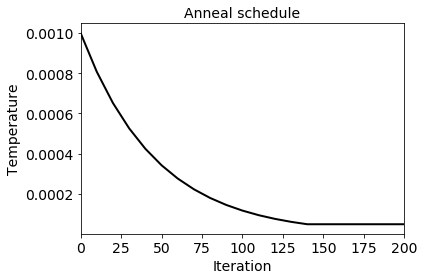

[Basinhopping] Finished optimizing 1 sequences.
Running seed 1...


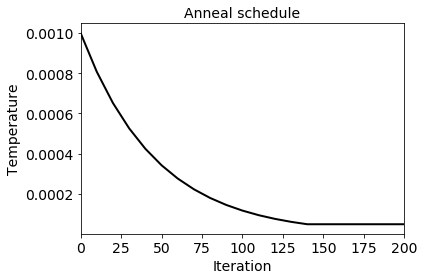

[Basinhopping] Finished optimizing 1 sequences.
Running seed 2...


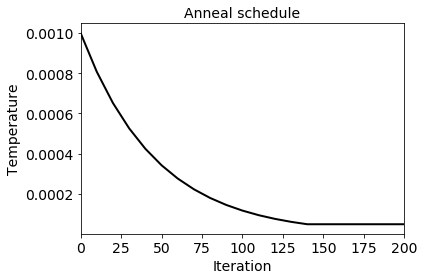

[Basinhopping] Finished optimizing 1 sequences.
Experiment name = Basinhopping 1/0.01
Eval mode = basinhopping
Normalize logits = False
Running seed 0...


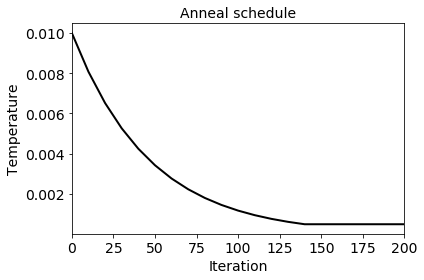

[Basinhopping] Finished optimizing 1 sequences.
Running seed 1...


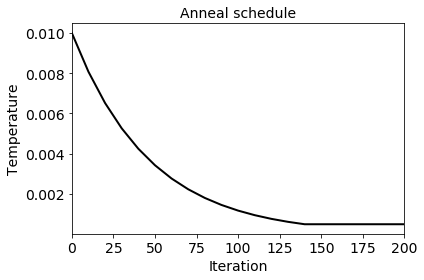

[Basinhopping] Finished optimizing 1 sequences.
Running seed 2...


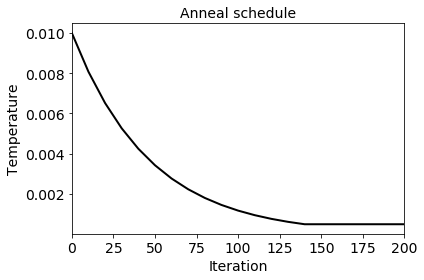

[Basinhopping] Finished optimizing 1 sequences.
Experiment name = Basinhopping 1/0.1
Eval mode = basinhopping
Normalize logits = False
Running seed 0...


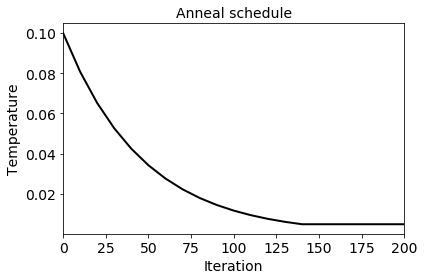

[Basinhopping] Finished optimizing 1 sequences.
Running seed 1...


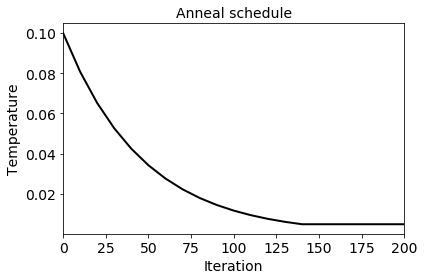

[Basinhopping] Finished optimizing 1 sequences.
Running seed 2...


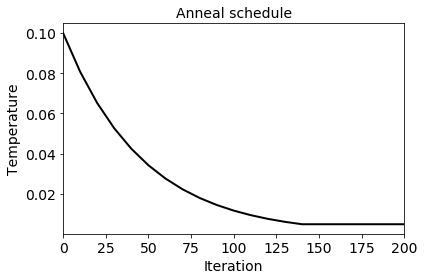

[Basinhopping] Finished optimizing 1 sequences.
Experiment name = Basinhopping 1/1.0
Eval mode = basinhopping
Normalize logits = False
Running seed 0...


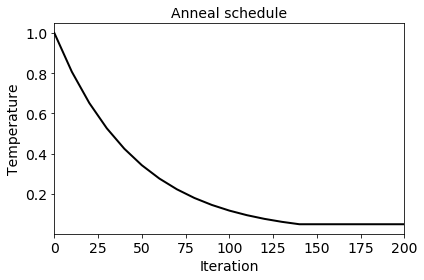

[Basinhopping] Finished optimizing 1 sequences.
Running seed 1...


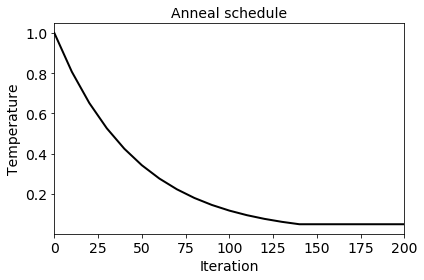

[Basinhopping] Finished optimizing 1 sequences.
Running seed 2...


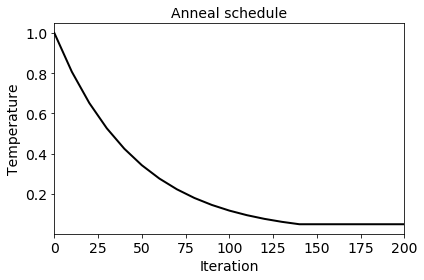

[Basinhopping] Finished optimizing 1 sequences.
Experiment name = Sampled
Eval mode = sample
Normalize logits = False
Running seed 0...
Optimizing objective 0...
No weights copied.
No weights copied.
Epoch 1/1
200/200 [==============================] - 53s 266ms/step - loss: 5.0003
Running seed 1...
Optimizing objective 0...
No weights copied.
No weights copied.
Epoch 1/1
200/200 [==============================] - 52s 260ms/step - loss: 4.9848
Running seed 2...
Optimizing objective 0...
No weights copied.
No weights copied.
Epoch 1/1
200/200 [==============================] - 52s 260ms/step - loss: 5.0264
Experiment name = Sampled-IN
Eval mode = sample
Normalize logits = True
Running seed 0...
Optimizing objective 0...
No weights copied.
No weights copied.
Epoch 1/1
200/200 [==============================] - 53s 267ms/step - loss: 3.7495
Running seed 1...
Optimizing objective 0...
No weights copied.
No weights copied.
Epoch 1/1
200/200 [==============================] - 53s 267ms/step 

In [7]:

seeds = [1177, 14755, 252654]

#Run SeqProp Optimization

print("Running optimization experiment 'trRosetta Target Structure'")

#Number of PWMs to generate per objective
n_sequences = 1
#Number of One-hot sequences to sample from the PWM at each grad step
n_samples = 1
#Number of epochs per objective to optimize
n_epochs = 1
#Sequence length
seq_length = msa_one_hot.shape[2]
#Number of steps (grad updates) per epoch
steps_per_epoch = 200
#Number of One-hot validation sequences to sample from the PWM
n_valid_samples = 1

experiment_name_list = [
    'Basinhopping 1/0.001',
    'Basinhopping 1/0.01',
    'Basinhopping 1/0.1',
    'Basinhopping 1/1.0',
    'Sampled',
    'Sampled-IN'
]

eval_mode_list = [
    'basinhopping',
    'basinhopping',
    'basinhopping',
    'basinhopping',
    'sample',
    'sample'
]

normalize_logits_list = [
    False,
    False,
    False,
    False,
    False,
    True
]

temperature_params_list = [
    [10, 1, 0.001, lambda t, curr_iter, t_init=0.001, total_iters=steps_per_epoch * n_epochs, t_min=0.05, exp_scale=1./0.7: t_init * t_min**(min(float(curr_iter / total_iters) * exp_scale, 1.0))],
    [10, 1, 0.01, lambda t, curr_iter, t_init=0.01, total_iters=steps_per_epoch * n_epochs, t_min=0.05, exp_scale=1./0.7: t_init * t_min**(min(float(curr_iter / total_iters) * exp_scale, 1.0))],
    [10, 1, 0.1, lambda t, curr_iter, t_init=0.1, total_iters=steps_per_epoch * n_epochs, t_min=0.05, exp_scale=1./0.7: t_init * t_min**(min(float(curr_iter / total_iters) * exp_scale, 1.0))],
    [10, 1, 1.0, lambda t, curr_iter, t_init=1.0, total_iters=steps_per_epoch * n_epochs, t_min=0.05, exp_scale=1./0.7: t_init * t_min**(min(float(curr_iter / total_iters) * exp_scale, 1.0))],
    
    [None, None, None, None],
    [None, None, None, None]
]

result_dict = {
    'Basinhopping 1/0.001' : {},
    'Basinhopping 1/0.01' : {},
    'Basinhopping 1/0.1' : {},
    'Basinhopping 1/1.0' : {},
    'Sampled' : {},
    'Sampled-In' : {}
}

for experiment_name, eval_mode, normalize_logits, temperature_params in zip(experiment_name_list, eval_mode_list, normalize_logits_list, temperature_params_list) :
    
    print("Experiment name = " + str(experiment_name))
    print("Eval mode = " + str(eval_mode))
    print("Normalize logits = " + str(normalize_logits))

    for rand_seed_ix, rand_seed in enumerate(seeds) :
    
        print("Running seed " + str(rand_seed_ix) + "...")

        K.clear_session()

        set_seed(rand_seed)

        losses, val_losses, val_losses_smooth_kl = zip(*[
            get_kl_loss(
                t_pd,
                t_pt,
                t_pp,
                t_po
            )
        ])

        transforms = [
            None
        ]

        opt_pwms, train_histories, valid_histories, valid_histories_smooth_kl = run_seqprop(losses, val_losses, val_losses_smooth_kl, transforms, [temperature_params], [t_pd, t_pt, t_pp, t_po], [msa_one_hot], seq_length, n_sequences, n_samples, n_valid_samples, eval_mode, normalize_logits, n_epochs, steps_per_epoch)

        opt_pwm, train_history, valid_history, valid_history_smooth_kl = opt_pwms[0], train_histories[0], valid_histories[0], valid_histories_smooth_kl[0]

        if rand_seed_ix > 0 :
            result_dict[experiment_name]['train_history'].val_loss_history.append(train_history.val_loss_history)
            result_dict[experiment_name]['valid_history'].val_loss_history.append(valid_history.val_loss_history)
            result_dict[experiment_name]['valid_history_smooth_kl'].val_loss_history.append(valid_history_smooth_kl.val_loss_history)
            
        else :
            train_history.val_loss_history = [train_history.val_loss_history]
            valid_history.val_loss_history = [valid_history.val_loss_history]
            valid_history_smooth_kl.val_loss_history = [valid_history_smooth_kl.val_loss_history]
            
            result_dict[experiment_name] = {
                'opt_pwm' : opt_pwm,
                'train_history' : train_history,
                'valid_history' : valid_history,
                'valid_history_smooth_kl' : valid_history_smooth_kl
            }
    
    result_dict[experiment_name]['train_history'].val_loss_history = np.median(np.array(result_dict[experiment_name]['train_history'].val_loss_history), axis=0).tolist()
    result_dict[experiment_name]['valid_history'].val_loss_history = np.median(np.array(result_dict[experiment_name]['valid_history'].val_loss_history), axis=0).tolist()
    result_dict[experiment_name]['valid_history_smooth_kl'].val_loss_history = np.median(np.array(result_dict[experiment_name]['valid_history_smooth_kl'].val_loss_history), axis=0).tolist()


In [8]:
from definitions.trrosetta_single_model import reweight, msa2pssm, fast_dca, InstanceNormalization

ckpt = "../../../trRosetta/network/model2019_07/model.xaa"

saved_predictor = load_model(ckpt + ".h5", custom_objects = {
    'InstanceNormalization' : InstanceNormalization,
    'reweight' : reweight,
    'wmin' : 0.8,
    'msa2pssm' : msa2pssm,
    'tf' : tf,
    'fast_dca' : fast_dca
})


Experiment name = Basinhopping 1/0.001


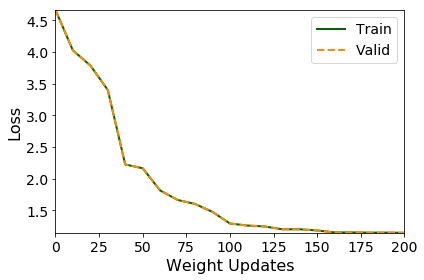

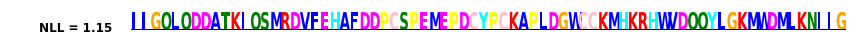

>seqprop_Basinhopping 1/0.001_0
IIGQLQDDATKIQSMRDVFEHAFDDPCSPEMEPDCYPCKAPLDGWCCKMHKRHWVDQQYLGKMWDMLKNIIG
final_loss_val = 1.535


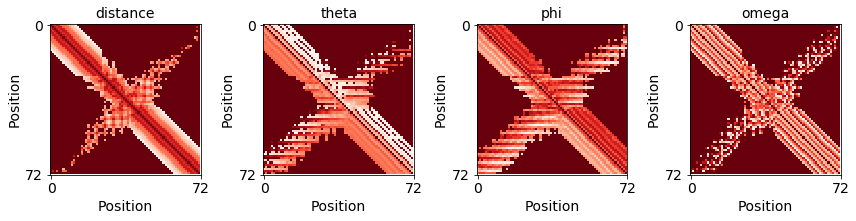

Experiment name = Basinhopping 1/0.01


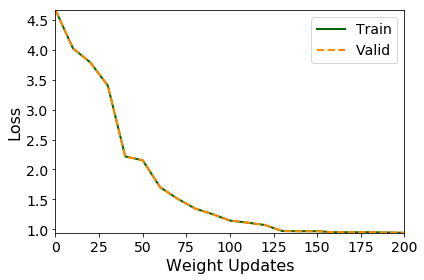

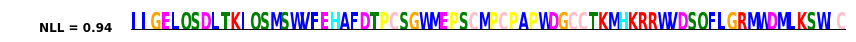

>seqprop_Basinhopping 1/0.01_0
IIGELQSDLTKIQSMSWVFEHAFDTPCSGWMEPSCMPCPAPWDGCCTKMHKRRWVDSQFLGRMWDMLKSWIC
final_loss_val = 1.5053


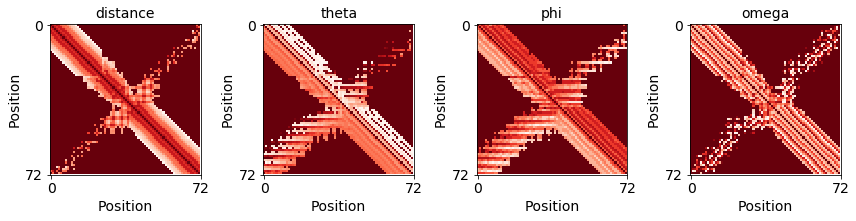

Experiment name = Basinhopping 1/0.1


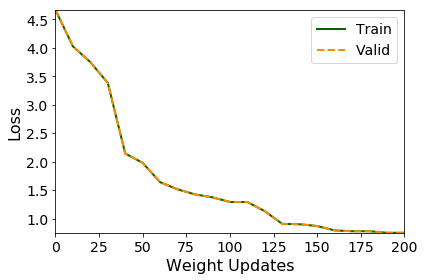

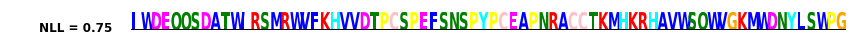

>seqprop_Basinhopping 1/0.1_0
IWDEQQSDATWIRSMRWVFKHVVDTPCSPEFSNSPYPCEAPNRACCTKMHKRHAVWSQWVGKMWDNYLSWPG
final_loss_val = 1.3497


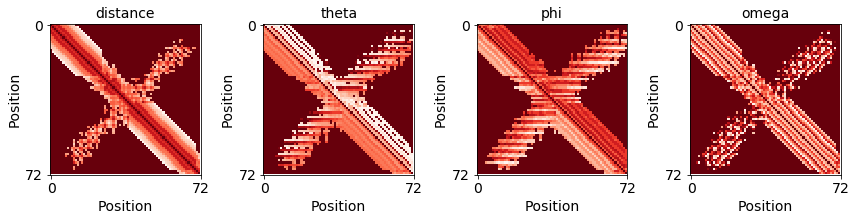

Experiment name = Basinhopping 1/1.0


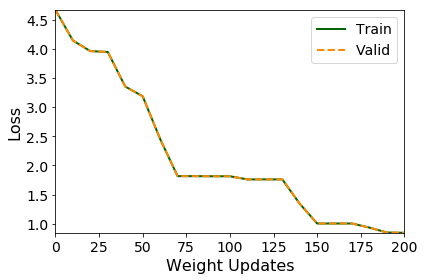

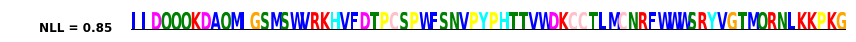

>seqprop_Basinhopping 1/1.0_0
IIDQQQKDAQMIGSMSWVRKHVFDTPCSPWFSNVPYPHTTVWDKCCTLMCNRFWWWSRYVGTMQRNLKKPKG
final_loss_val = 1.8451


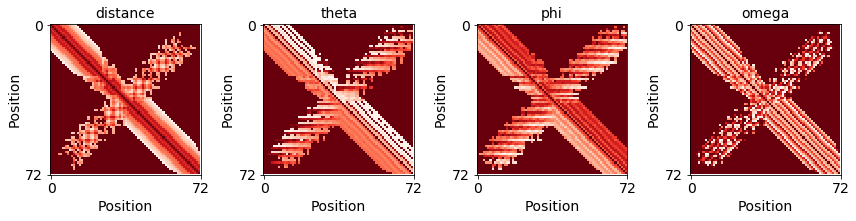

Experiment name = Sampled


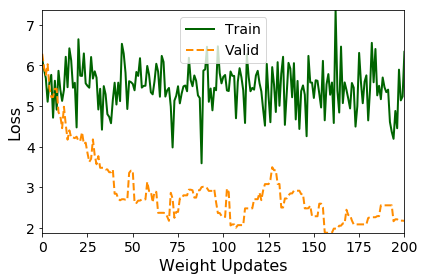

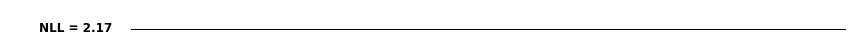

>seqprop_Sampled_0
GGDPNTDQTCALYYWWVMIEAYIIMVMMELPRENKHNDNPPPPPTPQYPWMELFWYAAYCMFHFADGDNQIC
final_loss_val = 3.1684


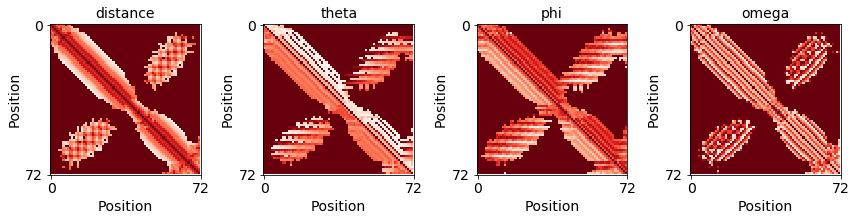

Experiment name = Sampled-IN


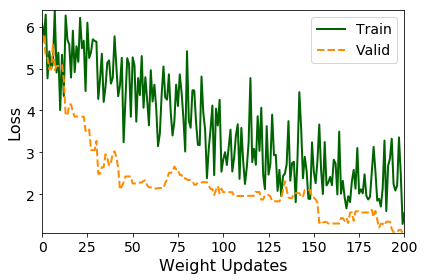

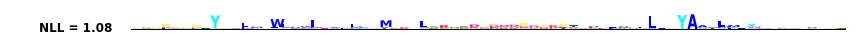

>seqprop_Sampled-IN_0
GGGPSPPAYQALMEWINWIFALIAVMKRHLSRNSDRGDDPDPKPTSQELNTILFQYAAWLMSYFARWGNQRP
final_loss_val = 1.079


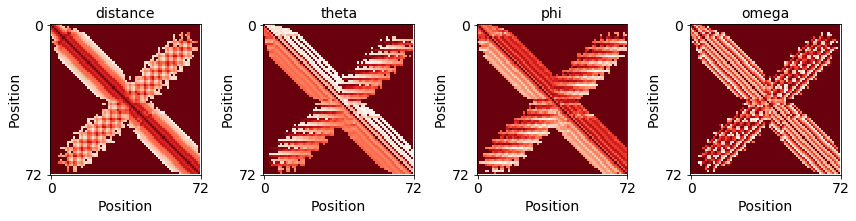

--- Comparison of loss convergence ---


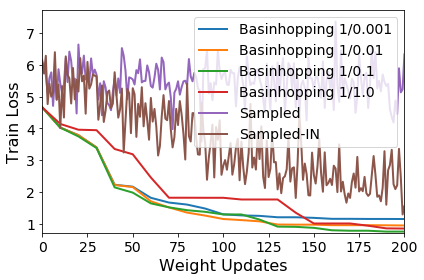

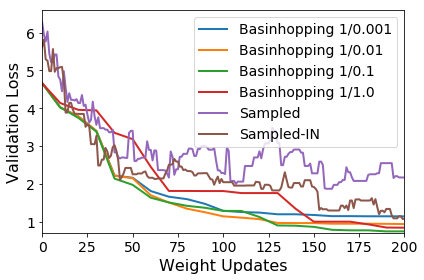

In [9]:

save_figs = True
fig_prefix = "eval_seqprop_rosetta_TR005257_no_msa_and_basinhopping_kl_experiment_200_updates_"


alphabet_order = "ARNDCQEGHILKMFPSTWYV"#"-"
inv_residue_map = {
    map_key : map_val for map_key, map_val in enumerate(alphabet_order)
}


for experiment_ix, experiment_name in enumerate(experiment_name_list) :
    
    print("Experiment name = " + str(experiment_name))

    opt_pwm = result_dict[experiment_name]['opt_pwm']
    train_history = result_dict[experiment_name]['train_history']
    valid_history = result_dict[experiment_name]['valid_history']

    #Store statistics for optimized sequences

    fig_name = fig_prefix + experiment_name.replace(" ", "_",).replace("/", "-",).replace(".", "_",) + "_" if save_figs else None

    f = plt.figure(figsize=(6, 4))
    
    n_x_coords = len(np.array(train_history.val_loss_history))
    x_coord_scale = (n_epochs * steps_per_epoch) / (n_x_coords - 1) #+ 1

    l1 = plt.plot(np.arange(n_x_coords) * x_coord_scale, np.array(train_history.val_loss_history) / n_sequences, color='darkgreen', linewidth=2, linestyle='-', label='Train')
    l2 = plt.plot(np.arange(n_x_coords) * x_coord_scale, np.array(valid_history.val_loss_history), color='darkorange', linewidth=2, linestyle='--', label='Valid')

    plt.xlabel("Weight Updates", fontsize=16)
    plt.ylabel("Loss", fontsize=16)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)

    plt.xlim(0, n_epochs * steps_per_epoch)
    plt.ylim(min(np.min(train_history.val_loss_history) / n_sequences, np.min(valid_history.val_loss_history)), max(np.max(train_history.val_loss_history) / n_sequences, np.max(valid_history.val_loss_history)))

    plt.legend(handles=[l1[0], l2[0]], fontsize=14)
    plt.tight_layout()

    if save_figs :
        plt.savefig(fig_name + '_loss.png', transparent=True, dpi=150)
        plt.savefig(fig_name + '_loss.svg')
        plt.savefig(fig_name + '_loss.eps')

    plt.show()
    
    #Print optimized sequence details
    
    final_kl_loss = valid_history.val_loss_history[-1]

    #Visualize PWM and get consensus sequence

    plot_protein_logo(inv_residue_map, opt_pwm[0, :, :, 0], "NLL", round(final_kl_loss, 2), sequence_template='$' * opt_pwm.shape[1], figsize=(12, 0.65), width_ratios=[1, 7], logo_height=1.0, plot_start=0, plot_end=opt_pwm.shape[1])

    print(">seqprop_" + experiment_name + "_0")

    seq = ""
    for j in range(opt_pwm.shape[1]) :
        decoded_residue = inv_residue_map[int(np.argmax(opt_pwm[0, j, :, 0]))]
        seq += decoded_residue

    print(seq)
    
    one_hot = np.zeros((1, opt_pwm.shape[1], opt_pwm.shape[2]))
    for j in range(opt_pwm.shape[1]) :
        max_j = int(np.argmax(opt_pwm[0, j, :, 0]))
        one_hot[0, j, max_j] = 1.
    
    msa_one_hot = np.expand_dims(one_hot, axis=0)
    msa_one_hot = np.concatenate([msa_one_hot, np.zeros((1, 1, msa_one_hot.shape[2], 1))], axis=-1)

    pd, pt, pp, po = saved_predictor.predict(x=[one_hot, msa_one_hot], batch_size=1)
    
    t_dist = np.clip(t_pd, 1e-7, 1. - 1e-7)
    t_theta = np.clip(t_pt, 1e-7, 1. - 1e-7)
    t_phi = np.clip(t_pp, 1e-7, 1. - 1e-7)
    t_omega = np.clip(t_po, 1e-7, 1. - 1e-7)
    
    kl_dist = np.mean(np.sum(t_dist * np.log(t_dist / pd), axis=-1))
    kl_theta = np.mean(np.sum(t_theta * np.log(t_theta / pt), axis=-1))
    kl_phi = np.mean(np.sum(t_phi * np.log(t_phi / pp), axis=-1))
    kl_omega = np.mean(np.sum(t_omega * np.log(t_omega / po), axis=-1))

    final_loss_val = kl_dist + kl_theta + kl_phi + kl_omega
    
    print("final_loss_val = " + str(round(final_loss_val, 4)))
    
    f, ax_list = plt.subplots(1, 4, figsize=(12, 3))
    
    p_list = [
        [pd, 'distance', ax_list[0]],
        [pt, 'theta', ax_list[1]],
        [pp, 'phi', ax_list[2]],
        [po, 'omega', ax_list[3]]
    ]

    for p_keras, p_name, p_ax in p_list :

        p_keras_vals = np.argmax(p_keras[0, ...], axis=-1)

        p_ax.imshow(np.max(p_keras_vals) - p_keras_vals, cmap="Reds", vmin=0, vmax=np.max(p_keras_vals))

        p_ax.set_title(p_name, fontsize=14)
        p_ax.set_xlabel("Position", fontsize=14)
        p_ax.set_ylabel("Position", fontsize=14)
        
        plt.sca(p_ax)
        
        plt.xticks([0, p_keras_vals.shape[0]], [0, p_keras_vals.shape[0]], fontsize=14)
        plt.yticks([0, p_keras_vals.shape[1]], [0, p_keras_vals.shape[1]], fontsize=14)

    plt.tight_layout()
    
    if save_figs :
        plt.savefig(fig_name + '_p_distribs.png', transparent=True, dpi=150)
        plt.savefig(fig_name + '_p_distribs.svg')
        plt.savefig(fig_name + '_p_distribs.eps')
    
    plt.show()


print("--- Comparison of loss convergence ---")

for history_prefix in ['train', 'valid'] :

    loss_normalizer = n_sequences if history_prefix == 'train' else 1.
    y_label_prefix = 'Train' if history_prefix == 'train' else 'Validation'
    
    f = plt.figure(figsize=(6, 4))

    ls = []
    min_y_val = 1000.
    max_y_val = -1000.
    
    for experiment_ix, experiment_name in enumerate(experiment_name_list) :
        curr_history = result_dict[experiment_name][history_prefix + '_history']
        
        n_x_coords = len(np.array(curr_history.val_loss_history))
        x_coord_scale = (n_epochs * steps_per_epoch) / (n_x_coords - 1) #+ 1

        l1 = plt.plot(np.arange(n_x_coords) * x_coord_scale, np.array(curr_history.val_loss_history) / loss_normalizer, linewidth=2, linestyle='-', label=experiment_name)
        ls.append(l1[0])

        min_y_val = min(min_y_val, np.min(curr_history.val_loss_history) / loss_normalizer)
        max_y_val = max(max_y_val, np.max(curr_history.val_loss_history) / loss_normalizer)

    min_y_val = min_y_val - 0.05 * np.abs(min_y_val)
    max_y_val = max_y_val + 0.05 * np.abs(max_y_val)
    
    plt.xlabel("Weight Updates", fontsize=16)
    plt.ylabel(y_label_prefix + " Loss", fontsize=16)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)

    plt.xlim(0, n_epochs * steps_per_epoch)
    plt.ylim(min_y_val, max_y_val)

    plt.legend(handles=ls, fontsize=14)
    plt.tight_layout()

    if save_figs :
        plt.savefig(fig_prefix + history_prefix + '_loss_cmp.png', transparent=True, dpi=150)
        plt.savefig(fig_prefix + history_prefix + '_loss_cmp.svg')
        plt.savefig(fig_prefix + history_prefix + '_loss_cmp.eps')

    plt.show()


Experiment name = Basinhopping 1/0.001


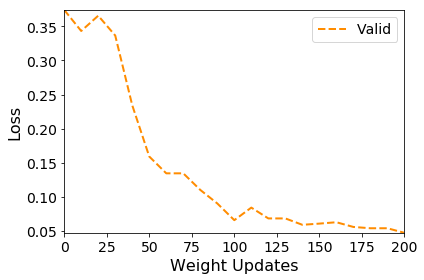

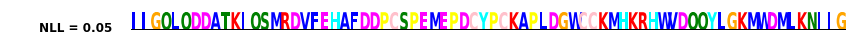

>seqprop_Basinhopping 1/0.001_0
IIGQLQDDATKIQSMRDVFEHAFDDPCSPEMEPDCYPCKAPLDGWCCKMHKRHWVDQQYLGKMWDMLKNIIG
final_loss_val = 0.1098


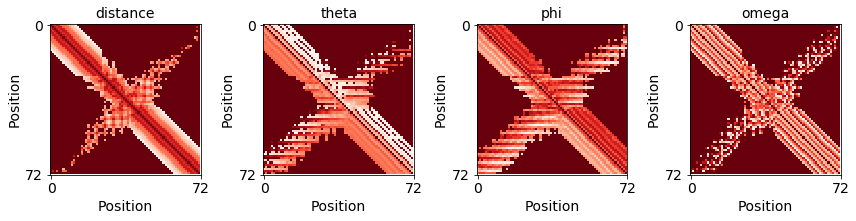

Experiment name = Basinhopping 1/0.01


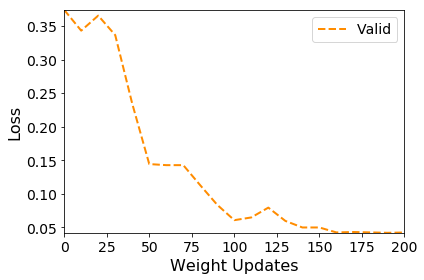

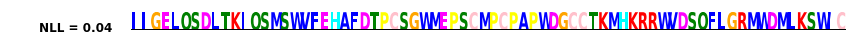

>seqprop_Basinhopping 1/0.01_0
IIGELQSDLTKIQSMSWVFEHAFDTPCSGWMEPSCMPCPAPWDGCCTKMHKRRWVDSQFLGRMWDMLKSWIC
final_loss_val = 0.1038


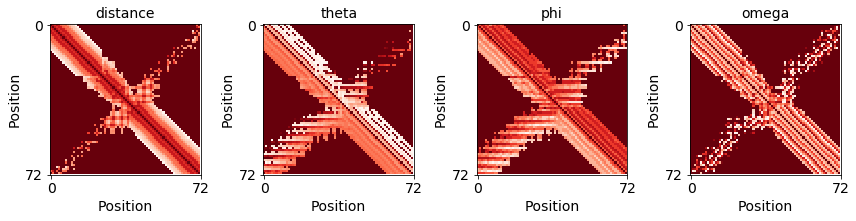

Experiment name = Basinhopping 1/0.1


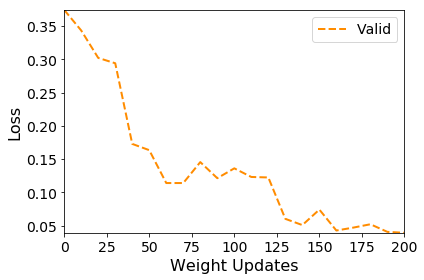

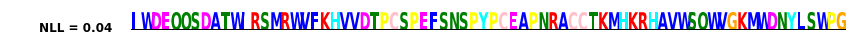

>seqprop_Basinhopping 1/0.1_0
IWDEQQSDATWIRSMRWVFKHVVDTPCSPEFSNSPYPCEAPNRACCTKMHKRHAVWSQWVGKMWDNYLSWPG
final_loss_val = 0.1149


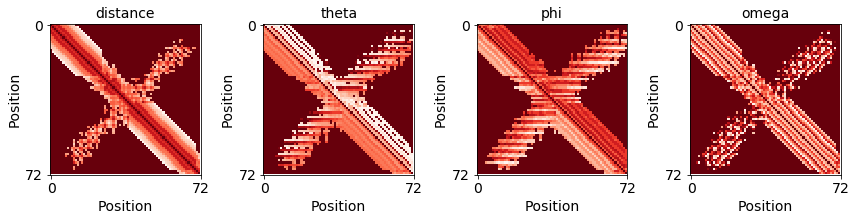

Experiment name = Basinhopping 1/1.0


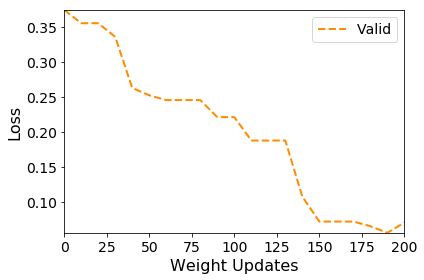

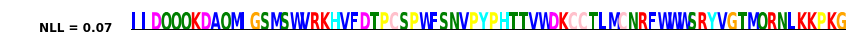

>seqprop_Basinhopping 1/1.0_0
IIDQQQKDAQMIGSMSWVRKHVFDTPCSPWFSNVPYPHTTVWDKCCTLMCNRFWWWSRYVGTMQRNLKKPKG
final_loss_val = 0.1188


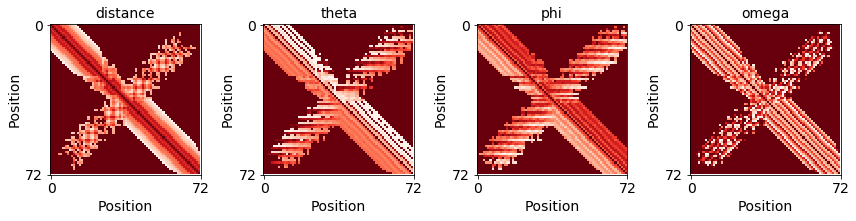

Experiment name = Sampled


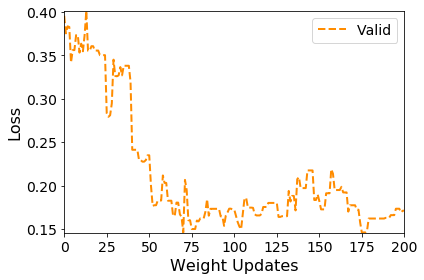

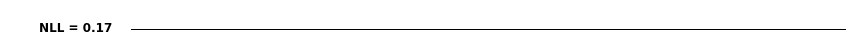

>seqprop_Sampled_0
GGDPNTDQTCALYYWWVMIEAYIIMVMMELPRENKHNDNPPPPPTPQYPWMELFWYAAYCMFHFADGDNQIC
final_loss_val = 0.171


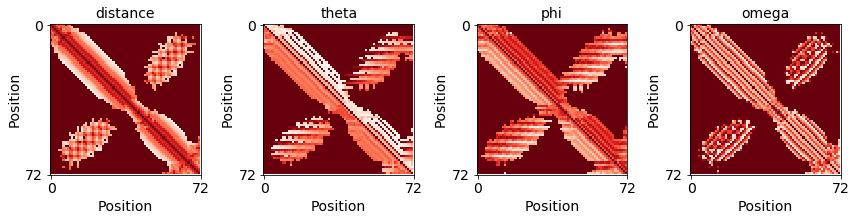

Experiment name = Sampled-IN


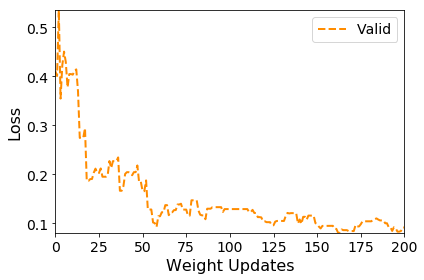

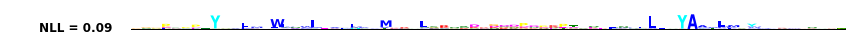

>seqprop_Sampled-IN_0
GGGPSPPAYQALMEWINWIFALIAVMKRHLSRNSDRGDDPDPKPTSQELNTILFQYAAWLMSYFARWGNQRP
final_loss_val = 0.056


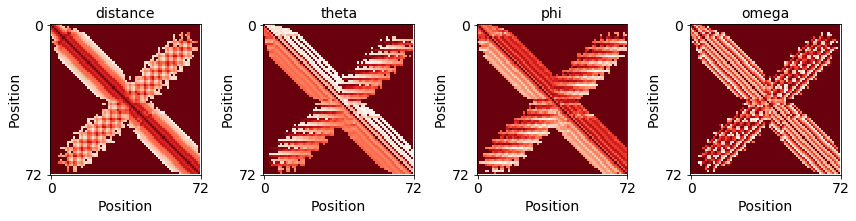

--- Comparison of loss convergence ---


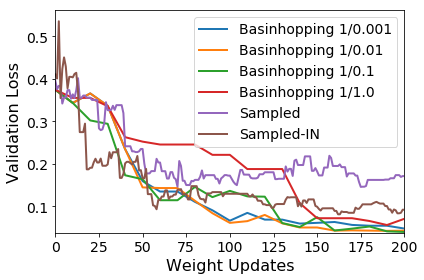

In [10]:

save_figs = True
fig_prefix = "eval_seqprop_rosetta_TR005257_no_msa_and_basinhopping_smooth_kl_experiment_200_updates_"


alphabet_order = "ARNDCQEGHILKMFPSTWYV"#"-"
inv_residue_map = {
    map_key : map_val for map_key, map_val in enumerate(alphabet_order)
}


for experiment_ix, experiment_name in enumerate(experiment_name_list) :
    
    print("Experiment name = " + str(experiment_name))

    opt_pwm = result_dict[experiment_name]['opt_pwm']
    valid_history = result_dict[experiment_name]['valid_history_smooth_kl']

    #Store statistics for optimized sequences

    fig_name = fig_prefix + experiment_name.replace(" ", "_",).replace("/", "-",).replace(".", "_",) + "_" if save_figs else None

    f = plt.figure(figsize=(6, 4))
    
    n_x_coords = len(np.array(valid_history.val_loss_history))
    x_coord_scale = (n_epochs * steps_per_epoch) / (n_x_coords - 1) #+ 1

    l2 = plt.plot(np.arange(n_x_coords) * x_coord_scale, np.array(valid_history.val_loss_history), color='darkorange', linewidth=2, linestyle='--', label='Valid')

    plt.xlabel("Weight Updates", fontsize=16)
    plt.ylabel("Loss", fontsize=16)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)

    plt.xlim(0, n_epochs * steps_per_epoch)
    plt.ylim(np.min(valid_history.val_loss_history), np.max(valid_history.val_loss_history))

    plt.legend(handles=[l2[0]], fontsize=14)
    plt.tight_layout()

    if save_figs :
        plt.savefig(fig_name + '_loss.png', transparent=True, dpi=150)
        plt.savefig(fig_name + '_loss.svg')
        plt.savefig(fig_name + '_loss.eps')

    plt.show()
    
    #Print optimized sequence details
    
    final_kl_loss = valid_history.val_loss_history[-1]

    #Visualize PWM and get consensus sequence

    plot_protein_logo(inv_residue_map, opt_pwm[0, :, :, 0], "NLL", round(final_kl_loss, 2), sequence_template='$' * opt_pwm.shape[1], figsize=(12, 0.65), width_ratios=[1, 7], logo_height=1.0, plot_start=0, plot_end=opt_pwm.shape[1])

    print(">seqprop_" + experiment_name + "_0")

    seq = ""
    for j in range(opt_pwm.shape[1]) :
        decoded_residue = inv_residue_map[int(np.argmax(opt_pwm[0, j, :, 0]))]
        seq += decoded_residue

    print(seq)
    
    one_hot = np.zeros((1, opt_pwm.shape[1], opt_pwm.shape[2]))
    for j in range(opt_pwm.shape[1]) :
        max_j = int(np.argmax(opt_pwm[0, j, :, 0]))
        one_hot[0, j, max_j] = 1.
    
    msa_one_hot = np.expand_dims(one_hot, axis=0)
    msa_one_hot = np.concatenate([msa_one_hot, np.zeros((1, 1, msa_one_hot.shape[2], 1))], axis=-1)

    pd, pt, pp, po = saved_predictor.predict(x=[one_hot, msa_one_hot], batch_size=1)
    
    t_dist = np.clip(t_pd, 1e-7, 1. - 1e-7)
    t_theta = np.clip(t_pt, 1e-7, 1. - 1e-7)
    t_phi = np.clip(t_pp, 1e-7, 1. - 1e-7)
    t_omega = np.clip(t_po, 1e-7, 1. - 1e-7)
    
    pd_val = np.sum(pd * np.tile(np.reshape(np.arange(pd.shape[3]), (1, 1, 1, pd.shape[3])), (1, pd.shape[1], pd.shape[2], 1)), axis=-1) / pd.shape[3]
    pt_val = np.sum(pt * np.tile(np.reshape(np.arange(pt.shape[3]), (1, 1, 1, pt.shape[3])), (1, pt.shape[1], pt.shape[2], 1)), axis=-1) / pt.shape[3]
    pp_val = np.sum(pp * np.tile(np.reshape(np.arange(pp.shape[3]), (1, 1, 1, pp.shape[3])), (1, pp.shape[1], pp.shape[2], 1)), axis=-1) / pp.shape[3]
    po_val = np.sum(po * np.tile(np.reshape(np.arange(po.shape[3]), (1, 1, 1, po.shape[3])), (1, po.shape[1], po.shape[2], 1)), axis=-1) / po.shape[3]
    
    td_val = np.sum(t_dist * np.tile(np.reshape(np.arange(t_dist.shape[3]), (1, 1, 1, t_dist.shape[3])), (1, t_dist.shape[1], t_dist.shape[2], 1)), axis=-1) / t_dist.shape[3]
    tt_val = np.sum(t_theta * np.tile(np.reshape(np.arange(t_theta.shape[3]), (1, 1, 1, t_theta.shape[3])), (1, t_theta.shape[1], t_theta.shape[2], 1)), axis=-1) / t_theta.shape[3]
    tp_val = np.sum(t_phi * np.tile(np.reshape(np.arange(t_phi.shape[3]), (1, 1, 1, t_phi.shape[3])), (1, t_phi.shape[1], t_phi.shape[2], 1)), axis=-1) / t_phi.shape[3]
    to_val = np.sum(t_omega * np.tile(np.reshape(np.arange(t_omega.shape[3]), (1, 1, 1, t_omega.shape[3])), (1, t_omega.shape[1], t_omega.shape[2], 1)), axis=-1) / t_omega.shape[3]
    
    kl_dist = np.mean(td_val * np.log(td_val / pd_val))
    kl_theta = np.mean(tt_val * np.log(tt_val / pt_val))
    kl_phi = np.mean(tp_val * np.log(tp_val / pp_val))
    kl_omega = np.mean(to_val * np.log(to_val / po_val))

    final_loss_val = kl_dist + kl_theta + kl_phi + kl_omega
    
    print("final_loss_val = " + str(round(final_loss_val, 4)))
    
    f, ax_list = plt.subplots(1, 4, figsize=(12, 3))
    
    p_list = [
        [pd, 'distance', ax_list[0]],
        [pt, 'theta', ax_list[1]],
        [pp, 'phi', ax_list[2]],
        [po, 'omega', ax_list[3]]
    ]

    for p_keras, p_name, p_ax in p_list :

        p_keras_vals = np.argmax(p_keras[0, ...], axis=-1)

        p_ax.imshow(np.max(p_keras_vals) - p_keras_vals, cmap="Reds", vmin=0, vmax=np.max(p_keras_vals))

        p_ax.set_title(p_name, fontsize=14)
        p_ax.set_xlabel("Position", fontsize=14)
        p_ax.set_ylabel("Position", fontsize=14)
        
        plt.sca(p_ax)
        
        plt.xticks([0, p_keras_vals.shape[0]], [0, p_keras_vals.shape[0]], fontsize=14)
        plt.yticks([0, p_keras_vals.shape[1]], [0, p_keras_vals.shape[1]], fontsize=14)

    plt.tight_layout()
    
    if save_figs :
        plt.savefig(fig_name + '_p_distribs.png', transparent=True, dpi=150)
        plt.savefig(fig_name + '_p_distribs.svg')
        plt.savefig(fig_name + '_p_distribs.eps')
    
    plt.show()


print("--- Comparison of loss convergence ---")

for history_prefix in ['valid'] :

    loss_normalizer = n_sequences if history_prefix == 'train' else 1.
    y_label_prefix = 'Train' if history_prefix == 'train' else 'Validation'
    
    f = plt.figure(figsize=(6, 4))

    ls = []
    min_y_val = 1000.
    max_y_val = -1000.
    
    for experiment_ix, experiment_name in enumerate(experiment_name_list) :
        curr_history = result_dict[experiment_name][history_prefix + '_history_smooth_kl']
        
        n_x_coords = len(np.array(curr_history.val_loss_history))
        x_coord_scale = (n_epochs * steps_per_epoch) / (n_x_coords - 1) #+ 1

        l1 = plt.plot(np.arange(n_x_coords) * x_coord_scale, np.array(curr_history.val_loss_history) / loss_normalizer, linewidth=2, linestyle='-', label=experiment_name)
        ls.append(l1[0])

        min_y_val = min(min_y_val, np.min(curr_history.val_loss_history) / loss_normalizer)
        max_y_val = max(max_y_val, np.max(curr_history.val_loss_history) / loss_normalizer)

    min_y_val = min_y_val - 0.05 * np.abs(min_y_val)
    max_y_val = max_y_val + 0.05 * np.abs(max_y_val)
    
    plt.xlabel("Weight Updates", fontsize=16)
    plt.ylabel(y_label_prefix + " Loss", fontsize=16)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)

    plt.xlim(0, n_epochs * steps_per_epoch)
    plt.ylim(min_y_val, max_y_val)

    plt.legend(handles=ls, fontsize=14)
    plt.tight_layout()

    if save_figs :
        plt.savefig(fig_prefix + history_prefix + '_loss_cmp.png', transparent=True, dpi=150)
        plt.savefig(fig_prefix + history_prefix + '_loss_cmp.svg')
        plt.savefig(fig_prefix + history_prefix + '_loss_cmp.eps')

    plt.show()
